In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
plt.rc('pdf', fonttype=42)

from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

BIG    = 22
MEDIUM = 20
FIGWIDTH= 12
WIDTH = 0.25  # the width of the bars
NARROW=0.2

XLINE  = 523.21
YLINE  = 0.002

colors = ['#E27100', '#1b85b8', '#559e83', '#b26167']

# Starting to define standardized colors
MAE_COLOR =colors[1]
TIME_COLOR=colors[0]

In [70]:
# Combining V100 and P100 on same row for same run
# We are deleting cases where there is no run for either of the architectures
# Every column name is appended with the name of the architecture (e.g. "_V100");
# This includes the `master_index` (e.g `master_index_V100`)

df_joined = pd.read_parquet('../df_master_joined.parquet')
df_joined.master_index_P100 = df_joined.master_index_P100.astype('int64') # Make sure index is integer
df_joined.master_index_V100 = df_joined.master_index_V100.astype('int64') # Make sure index is integer
df_joined.shape


# This is an "empty" dataframe (meaning no rows), containing
# column names for numerical data only.
# The column nmaes can be used to index the columns of the
# scaled data (in master_scaled_data.npy)

df_columns_only = pd.read_parquet('../df_column_reference.parquet')


# This is a 2-D numpy array corresponding to the numerical data in 'df_master.parquet'
# The data has been scaled using the StandardScaler in scikitlearn

# Notes: 
#   - The row indices correspond to the `master_index` column of 'df_master.parquet'
#   - The columns correspond to the columns in 'df_column_reference.parquet'.
#     (e.g. can use `df.get_loc(column-name)` to get the column index)

master_data_scaled = np.load('../master_scaled_data.npy')
master_data_scaled.shape

(78330, 116)

In [71]:
temp_col = df_joined['dram_write_throughput_P100'] + df_joined['dram_read_throughput_P100']
"""temp_col3 = df_joined['dram_write_throughput_V100'] + df_joined['dram_read_throughput_V100']
temp_col = df_joined['dram_write_throughput_P100']
temp_col2 = df_joined['dram_read_throughput_P100']
temp_col4 = df_joined['dram_write_throughput_V100']
temp_col5 = df_joined['dram_read_throughput_V100']
df_joined =df_joined[temp_col>1e9]
df_joined =df_joined[temp_col2>1e9]
df_joined =df_joined[temp_col4>1e9]
df_joined =df_joined[temp_col5>1e9]"""
#df_joined = df_joined[temp_col3>1e9]

df_joined =df_joined[temp_col>1e9]
#df_joined =df_joined[temp_col2>10e9]
#df_joined= df_joined[temp_col2>10e9]
#df_joined= df_joined[temp_col2>10e9]

In [72]:

df = df_joined.copy()  # Start with all of df_joined

# Target index and values (values are NOT in master_data_scaled)
target_index = df['master_index_V100'].values
target = df['memory_bound_V100'].values

# Training data index and values (values ARE in master_data_scaled)
data_index = df['master_index_P100'].values
data = master_data_scaled[ data_index ]

# Need to drop 'dram_read_throughput' and 'dram_write_throughput'
indices = []
for i, col in enumerate(df_columns_only.columns):
    if col not in ['dram_read_throughput', 'dram_write_throughput','dram_write_transactions','dram_read_transactions']:
    #if col not in not_import:
        indices.append(i)       
data = data[:,indices]

In [73]:
# Training data index and values (values ARE in master_data_scaled)
data_index = df['master_index_P100'].values
data = master_data_scaled[ data_index ]

top_features = ['gld_transactions', 'l2_write_transactions', 'l2_tex_write_transactions','tex_cache_transactions','gst_transactions']
# Need to drop 'dram_read_throughput' and 'dram_write_throughput'
indices = []
for i, col in enumerate(df_columns_only.columns):
    if col not in ['dram_read_throughput', 'dram_write_throughput','dram_write_transactions','dram_read_transactions']:
    #if col in top_features:
        indices.append(i)       
data = data[:,indices]

In [74]:
df_target = (df_joined['dram_read_throughput_V100'] + df_joined['dram_write_throughput_V100']).values
# Split the data for training
(
    X_train, X_test,
    y_train, y_test,
    #data_index_train, data_index_test,
    #target_index_train, target_index_test
) = train_test_split(
    data,
    df_target,
    #data_index,
    #target_index,
    random_state=42,
    test_size=.33
)

In [75]:
data.shape

(27105, 112)

In [76]:
clf = RandomForestRegressor(n_jobs=2, n_estimators=200, max_depth=100)
reg_model = clf.fit(X_train, y_train)
y_test_predict = clf.predict(X_test)

In [77]:
clf = RandomForestRegressor(n_jobs=2, n_estimators=200, max_depth=100)
reg_model = clf.fit(X_train, y_train)
y_test_predict = clf.predict(X_test)errors = abs(y_test_predict - y_test)/1024/1024/1024
y_test_predict_gb = y_test_predict/1024/1024/1024
y_test_gb = y_test/1024/1024/1024
mean_error = round(np.mean(errors),2)
print('Mean Absolute Error:', round(np.mean(errors),2))
print("Mean absolute percentage error:",mean_absolute_percentage_error(y_test_gb,y_test_predict_gb)*100)

Mean Absolute Error: 14.06
Mean absolute percentage error: 357.5644574092967


Text(0,0.5,'Predicted')

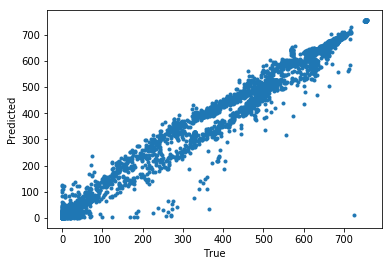

In [78]:
plt.plot(y_test/1024/1024/1024, y_test_predict/1024/1024/1024,'.')
plt.xlabel('True')
plt.ylabel('Predicted')